In [1]:
import os 
import pandas as pd
import numpy as np
import subprocess
import sys
import shutil
from distutils.dir_util import copy_tree
import distutils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib notebook


### Run a GGSHA model, and produce outlet file

Note that if you want to bring in a clean model from WMS its a good idea to save it in a folder and then have python move it around each time you run it so you are always starting from the same point you can do this with 

 . # This will copy out the project files from WORKING_MODEL to the RUN directory where Python runs the model  
copy_tree("RUN", 'WORKING_MODEL')

. # You also need to Copy in GSSHA exe from wherever you keep it here its in ".", "Data", "gssha.exe"
distutils.file_util.copy_file(os.path.join(".", "Data", "gssha.exe"), 'RUN')


Another note, if the cell below throws an error after switching into the RUN folder you might need to switch the kernal back out of it to keep the paths correct

In [21]:
RUN_dir = os.path.join('.', 'RUN')    # directory where the model is saved 
# PrjName

try: 
    # note GSSHA.exe has to be in the pwd of the kernal NOT the RUN directory
    subprocess.call('gssha.exe {}.prj'.format(PrjName),  cwd=RUN_dir) # shell=True)   
except: print("FAILED execution!! check to see, GSSHA.exe has to be in the pwd of the notebook kernal NOT in the RUN directory")

FAILed execution!! check to see, GSSHA.exe has to be in the pwd of the notebook kernal NOT in the RUN directory


In [14]:
pwd

'C:\\Users\\CS\\Desktop\\Local_Project_Folders\\AdSci_Watershed\\Scripts\\Command_Line_Bootcamp'

In [4]:
# Run the GSSHA process in the command line 

# Parameters
Runnable_model_folder = os.path.join(".", "RUN")  # this will take the model files in this folder and just run it, and save the outputs in the same folder. 

PrjName = "test5" # The Priject File name from the WMS save this is required


os.chdir(Runnable_model_folder)         # Change into the run directoy 
subprocess.call('gssha.exe {}.prj'.format(PrjName), shell=True)
os.chdir(os.path.join(".."))                # Change back out of run directory 


# Process the outlet file into a dataframe 

<IPython.core.display.Javascript object>


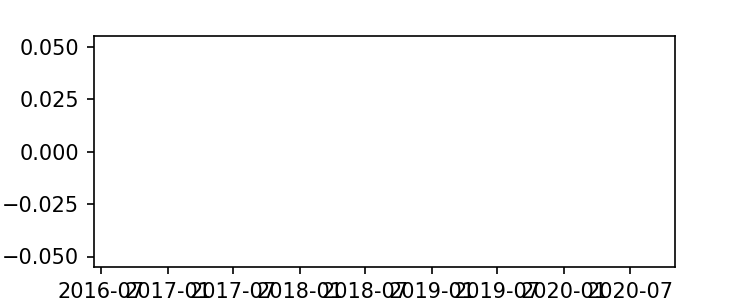

In [3]:
# Event Variables 
StartDate   =  "2018-08-23 00:00"


# Process outlet file from GSSHA into a pandas dataframe 
def process_otl_file(StartDate, OutletFile):

    # Create the start time object to enumerate the number of minutes in the outlet file 
    StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
    
    # read in the outlet file 
    OutHydro = pd.read_csv(OutletFile, names=["Minutes", "CFS"], delim_whitespace=True)
    
    # da magic: Turn stupid minutes into useful datetime objects 
    OutHydro["date"] = OutHydro["Minutes"].apply(lambda x: StartDateTime + timedelta(minutes=x))
    
    # Set the index to the date
    OutHydro.set_index("date", inplace=True)
    
    return OutHydro



# Process the Run's Output hydrograph into a dataframe 
OutletFile = os.path.join("RUN", PrjName)+".otl"
OutHydro = process_otl_file(StartDate, OutletFile)

# Plot it quick 
fig, ax = plt.subplots(figsize=(5, 2)); ax.plot(OutHydro['CFS'], '-', c='g', alpha=0.5, label="Modeled_CFS")

# Change the rainfall data 
Notes: 
- Input_Precip_File is a custom csv that contains your precip data 

In [4]:


def make_rain_gag_file(Input_Precip_File, FileNamePlace, StartDate, EndDate, Lat, Lon, GageName, Resampling_timestep_Mins,
           Precip_column_Name, ImpPrecip_units="Inches"):

    Full_Frame = pd.read_csv(Input_Precip_File, index_col=0, parse_dates=True)   # read in data 
    SliceFrame = Full_Frame[StartDate:EndDate]

    # Format date string for dumb file 
    SliceFrame_format = SliceFrame.copy()
    SliceFrame_format['da'] = SliceFrame_format.index.strftime('%Y %m %d %H %M')
    SliceFrame_format['datedumb'] = SliceFrame_format['da'].str[:]

    # Pull extranious columns 
    SliceFrame_format = SliceFrame_format[['datedumb', Precip_column_Name]]

    # Turn rain in to rain MM 
    if ImpPrecip_units == "Inches": 
        SliceFrame_format[Precip_column_Name+"_mm"] = SliceFrame_format[Precip_column_Name]*25.4 
        Precip_column_Name = Precip_column_Name+"_mm"
        

    # Round off the number of significant figs
    sigfigs = 3
    SliceFrame_format[Precip_column_Name] = SliceFrame_format[Precip_column_Name].round(sigfigs).apply(lambda x: 
                                                                                                 '{0:g}'.format(float(x)))
 
    # Put the GAGES card on EVery single row 
    SliceFrame_format["trash"] = "GAGES"

    # reorder columns 
    SliceFrame_format = SliceFrame_format[["trash", "datedumb", Precip_column_Name]]

    # Print it off to a txt file with no header, no index and space separator
    SliceFrame_format.to_csv(FileNamePlace, index=False, sep=' ', header = False) 

    # Remove dumb double quotes 
    with open(FileNamePlace,'r') as file:
        data = file.read()
        data = data.replace('"','')
    with open(FileNamePlace,'w') as file:    
        file.write(data)


    # Create the required header lines for WMS gag  files 
    AddLine = 'EVENT "Rain Gage" \nNRGAG 1 \nNRPDS {}\nCOORD {} {} "{}"'.format(len(SliceFrame_format),Lat, Lon, GageName)  

    with open(FileNamePlace, "r+") as f:
        old = f.read() # read everything in the file
        f.seek(0) # rewind
        f.write("{}\n".format(AddLine) + old) # write the new line before

    # Calculate the number of minutes to run the damn thing. 
    Total_Run_Length = Resampling_timestep_Mins*len(SliceFrame_format)
    print("Simulation time is {} minutes".format(Total_Run_Length))
    print("number of time rows is {}".format(len(SliceFrame_format)))
    
    return Total_Run_Length, SliceFrame_format

In [5]:
# set variables and create the new gag file. 
# note that this is taking data from "OBS_data_rain_Streams_2007-2021.csv for it to work you need a csv file formatted like this

# Precip variables
Input_Precip_File   =  os.path.join("..", "input_data", "OBS_data_rain_Streams_2007-2021.csv")  # note Date time Column needs to be called "datetime" 
Precip_column_Name       =  "rain_in"
ImpPrecip_units     =  "Inches"    # "Inches" or "mm"

# Event Variables 
StartDate   =  "2018-08-24 00:00"
EndDate     =    "2018-08-29 00:00"
Resampling_timestep_Mins = 30

# Rain Gauge Location info 
Lat  = 753354.0       # For Waihehe 753354,    # For WaiehuKou,"758000.0"
Lon  = 2314472.0       # For Waihehe 2314472,     # For WaiehuKou,"2315555.0" 
GageName    = "Gage2_Waihehe"


# Output Rain GAG file location 
FileNamePlace = os.path.join(".","RUN", "{}.gag".format(PrjName))

# Run the Rain Gauge Creation Function 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(
    Input_Precip_File, FileNamePlace, StartDate, EndDate, Lat, Lon, 
    GageName, Resampling_timestep_Mins,
           Precip_column_Name, ImpPrecip_units="Inches")

Simulation time is 7230 minutes
number of time rows is 241


### Modify the .prj file to chanfe the TOT_TIME card to whatever the total number of minutes output by the raingag function outputs 

In [6]:
# read in the .prj file as a 1 column csv
df = pd.read_csv(os.path.join(".", "RUN", "{}.prj".format(PrjName)), names=["moo"] )  # note names=moo is to make a column that will then get chopped off by numpy savetxt

# ID row of and change the TOT_TIME variable
singleCol = df.columns[0]                # this is the name of the single column
idx_tottime = df.loc[df[singleCol].str.contains("TOT_TIME", case=False)].index[0]  # this identifies the index of the TOT_TIME card
# Actually set the total time value to something else. 
df.loc[idx_tottime] = "TOT_TIME      {}".format(Total_Run_Length)

# Save the df back to a prj file (the np formulation seems to write better than the pd to csv one)
np.savetxt(os.path.join(".", "RUN", "{}.prj".format(PrjName)), df.values, fmt="%s")

#  Rerun and plot new model results 

<IPython.core.display.Javascript object>


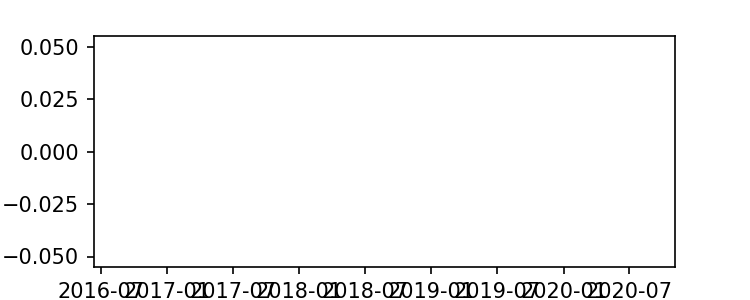

In [7]:
os.chdir(Runnable_model_folder)         # Change into the run directoy 
subprocess.call('gssha.exe {}.prj'.format(PrjName), shell=True)
os.chdir(os.path.join(".."))                # Change back out of run directory 


# Process the Run's Output hydrograph into a dataframe 
OutletFile = os.path.join("RUN", PrjName)+".otl"
OutHydro = process_otl_file(StartDate, OutletFile)

# Plot it quick 
fig, ax = plt.subplots(figsize=(5, 2)); ax.plot(OutHydro['CFS'], '-', c='g', alpha=0.5, label="Modeled_CFS")